# Short intro to Transfer learning ( Reusing Pretrained Layers)

- Its always a good idea to use transfer learning whenever possible for very deep NNs. 
- Tranfer learning will help with both speed up training and we could also use significantly less training data for the new model. 
- A detailed study of this kind of networks can be found in Chapter 14 of “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.”

## Key points to start with transfer learning 

- Transfer learning will work best when the inputs have similar low-level features. So if the inputs of the new data is of a different shpae compared to the already trained data, its better to reshape them through a preprocessing step.  
- The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.  
- Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.  
- The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, try keeping all the hidden layers and just replacing the output layer.  
- Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.  
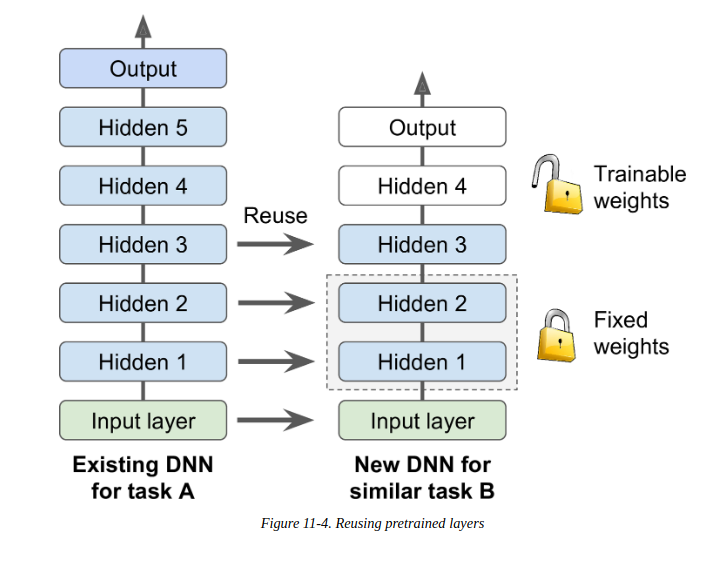
- Note that transfer learning dotn usually work well for shallow nets, its better saved for more complex deep networks like convolutional nets.

## Implementing in Keras

For demo purpose, we use the saved model from `../2_image_classsifier_seq' folder`. This corresponds to the image classifer we have saved previously.


In [20]:
import tensorflow as tf
from tensorflow import keras

#loading saved model
model_A = keras.models.load_model("saved_models/seq_image_classfr.h5")
#cloning the model A so it wont be affected later.
model_A_clone = keras.models.clone_model(model_A)
#transfering parameters from model A to B except the output layer
model_B_from_A = keras.models.Sequential(model_A_clone.layers[:-1])
#adding new single output to model_B (it could be whether something is ankle boot or not)
model_B_from_A.add(keras.layers.Dense(1, activation="sigmoid",name="new_output"))

- We should freeze more layers in the beginning so the high gradient in the beginning wont distort the already trained lower layers a lot. 
- Always compile the model once a layer is frozen/un-frozen
- Train the model for some epochs with this config and later unfreeze more layers sequentially.

In [23]:
#Freezing all except last(output) layer of model_B_from_A
for layer in model_B_from_A.layers[:-1]:
    layer.trainable = False
#Compiling the model again after freezin/unfreezin
model_B_from_A.compile(loss="binary_crossentropy", optimizer="sgd",
                      metrics=["accuracy"])

In [24]:
model_B_from_A.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
new_output (Dense)           (None, 1)                 101       
Total params: 265,701
Trainable params: 101
Non-trainable params: 265,600
_________________________________________________________________


Training the model for few epochs

    history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                               validation_data=(X_valid_B, y_valid_B))

    for layer in model_B_on_A.layers[:-1]:
        layer.trainable = True

    optimizer = keras.optimizers.SGD(lr=1e-4) # the default lr is 1e-2
    model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                         metrics=["accuracy"])
    history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                               validation_data=(X_valid_B, y_valid_B))


- As we unfreeze  more and moer layers, reduce the learning rate as well as above, to preserve the structure of the lower layers. 

### Pretraining on Auxiliary Task

- If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.  
